## 선형 회귀
선형 회귀는 종속 변수와 한개 이상의 독립 변수와의 선형 상관 관계를 모델링하는 회귀 분석 기법 <br>
용어를 종속 변수, 독립 변수를 다음 수식에서의 y, x 로 나타냄<br> 

$$ y = wx + b $$
$$ y = w_0x_0 + w_1x_1 + w_2x_2 + .... w_nx_n + b $$
$$ w : 계수(가중치) $$
$$ b : 절편(편향) $$

선형 회귀는 데이터가 분포되어 있는 공간에서 데이터를 가장 잘 표현하는 선을 하나 긋는 것이라고 표현할 수 있음.<br>

-선형 회귀의 비용 함수(손실 함수).

$$ Cost_{lr} = \sum_i{(y_i - \hat y_i)^2}$$
$$ \hat y_i = b + wx_i $$

실제 값 $y_i$와 회귀 모델이 출력한 $ \hat y $ 사이의 잔차의 제곱의 합을 최소화하는 w(계수\[가중치\])를 구하는 것이 목적 -> Least Square, 최소 제곱법 <br>
선형 회귀는 출력되는 y가 1개 또는 2개 이상인지의 유무에 따라 단변량, 다변량이라는 말이 붙는데, 이번 수업에서는 출력값인 y가 1개(단변량)라고 가정<br>
또한, 입력으로 들어가는 x가 1개 또는 2개 이상인지의 유무에 따라 단순(Simple), 다중(Multiple)이라는 말이 붙는데, 이번 실습에서는 다중 선형 회귀 분석에 대해서만 다룸
<br>

이 실습은 Tensorflow tutorial을 참고하여 재구성해서 만듬


### 추가
#### 선형 회귀의 4가지 기본 가정
선형 회귀 4가지 기본 가정
선형 회귀는 아래의 4가지 기본 가정을 만족함
1. 선형성
2. 독립성
3. 등분산성
4. 정규성
- 선형 회귀의 기본 가정 : https://kkokkilkon.tistory.com/175

In [1]:
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0


In [3]:
# dataset 다운로드
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 0us/step


'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      comment='\t', na_values="?",
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# na_values = "?" ?를 na로 인식
dataset[dataset["Horsepower"] == "?"]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# na 삭제
dataset = dataset.dropna()

In [8]:
# 길이 확인
len(dataset)

392

In [9]:
# index 초기화
dataset = dataset.reset_index(drop=True)

In [10]:
# pop list의 pop이랑 같다고 생각하면 됨
origin = dataset.pop('Origin')

In [11]:
origin.unique()

array([1, 3, 2])

In [12]:
# one-hot encoding - 범주형 데이터 처리 , 0 or 1로만 데이터를 나타냄
dataset['USA'] = (origin == 1)*1.0 # origin 이 1 이면 True 아니면 False / True == 1, False == 0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

In [13]:
temp = raw_dataset.copy()

In [14]:
pd.get_dummies(temp, columns=["Origin"]).head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [15]:
temp['Origin'] = temp['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
temp = pd.get_dummies(temp, columns=['Origin'], prefix="", prefix_sep="") # prefix="" prefix_sep=_
temp.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [16]:
# Train / Test 분리
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [17]:
# sample(frac=1)하면 데이터셋을 섞을 수 있음
temp.sample(frac=1)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
119,20.0,4,114.0,91.0,2582.0,14.0,73,1,0,0
14,24.0,4,113.0,95.0,2372.0,15.0,70,0,1,0
35,17.0,6,250.0,100.0,3329.0,15.5,71,0,0,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,0,0,1
73,13.0,8,307.0,130.0,4098.0,14.0,72,0,0,1
...,...,...,...,...,...,...,...,...,...,...
380,36.0,4,120.0,88.0,2160.0,14.5,82,0,1,0
259,20.8,6,200.0,85.0,3070.0,16.7,78,0,0,1
253,20.5,6,200.0,95.0,3155.0,18.2,78,0,0,1
144,31.0,4,76.0,52.0,1649.0,16.5,74,0,1,0


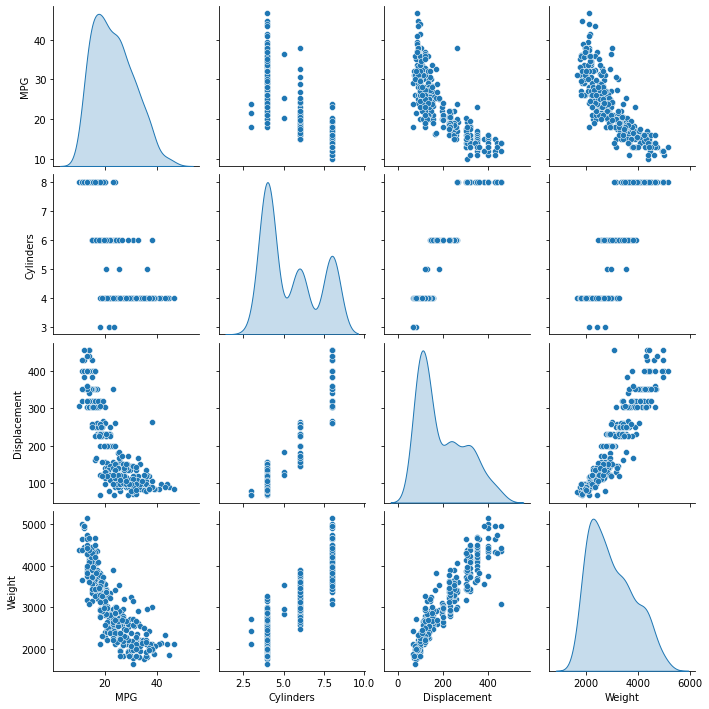

In [18]:
# 산점도
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [19]:
# train set 기술통계량
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [20]:
# target값 분리 - MPG 예측
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [21]:
# dataset 정규화
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [22]:
# sklearn 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [23]:
scaler = StandardScaler()

In [24]:
normed = scaler.fit_transform(train_dataset)

In [25]:
temp_df = pd.DataFrame(normed, columns=train_dataset.columns)

In [26]:
# tensorflow 정규화
import numpy as np 
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(temp))

In [27]:
# 모델의 가장 첫 번째 레이어에 넣어주면 됨
normalizer

In [28]:
# 컬럼
len(train_dataset.keys()), len(train_dataset.columns), train_dataset.shape[1]

(9, 9, 9)

In [29]:
# 모델 만들기 - 모델 만드는 방법은 다양한 방법이 있음
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), # 각각의 인자가 무엇을 뜻하는지 설명
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [30]:
model = build_model()

### MSE
평균 제곱 오차(MSE)는 오차 제곱의 평균을 나타내는 척도로 결과 값이 얼마나 정답과 떨어져있는지를 계산하는 척도<br>

In [31]:
# model 요약 - parameter 수 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Model 형태 찍어보기
from tensorflow.keras.utils import plot_model

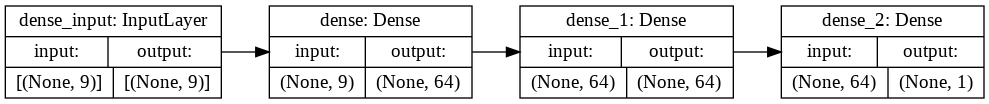

In [33]:
plot_model(model, show_shapes=True, rankdir="LR")

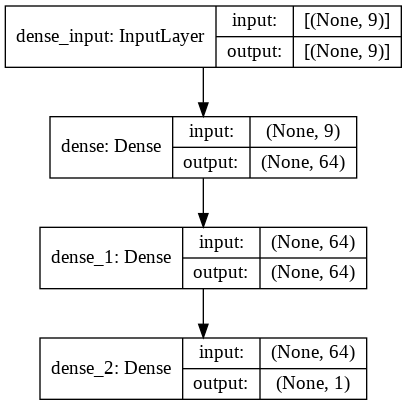

In [34]:
plot_model(model, show_shapes=True)

In [35]:
example_batch = normed_train_data[:10] # batch 10
example_result = model.predict(example_batch)
example_result

array([[-0.09978351],
       [ 0.23498058],
       [ 0.499107  ],
       [ 0.21608695],
       [ 0.17383286],
       [ 0.47976717],
       [ 0.16558485],
       [ 0.18886837],
       [ 0.12511696],
       [ 0.03434469]], dtype=float32)

In [37]:
%%time
model = build_model()
# full batch 
# 1000번 학습
EPOCHS = 1000
# validation data는 20%
history = model.fit(
  normed_train_data, train_labels, batch_size = len(normed_train_data),
  epochs=EPOCHS, validation_split = 0.2, verbose=0) # verbose=0 , 1, 2

CPU times: user 18 s, sys: 1.58 s, total: 19.6 s
Wall time: 18.2 s


In [38]:
%%time
model = build_model()
# stocastic batch 
# 1000번 학습
EPOCHS = 1000
# validation data는 20%
history = model.fit(
  normed_train_data, train_labels, batch_size = 1,
  epochs=EPOCHS, validation_split = 0.2, verbose=0) # verbose=0 , 1, 2

CPU times: user 7min 44s, sys: 29.5 s, total: 8min 13s
Wall time: 7min 22s


In [39]:
%%time
model = build_model()
# mini batch 
# 1000번 학습
EPOCHS = 1000
# validation data는 20%
history = model.fit(
  normed_train_data, train_labels, batch_size = 32,
  epochs=EPOCHS, validation_split = 0.2, verbose=0) # verbose=0 , 1, 2

CPU times: user 36.3 s, sys: 3.1 s, total: 39.4 s
Wall time: 32 s


In [40]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.627038,1.031040,2.627038,8.064749,2.199516,8.064749,995
996,2.675337,1.049773,2.675337,7.803946,2.142104,7.803946,996
997,2.513767,0.995966,2.513767,8.300436,2.184138,8.300436,997
998,2.677636,1.052377,2.677636,7.768106,2.172133,7.768106,998
999,2.618558,1.045150,2.618558,8.312014,2.276829,8.312014,999


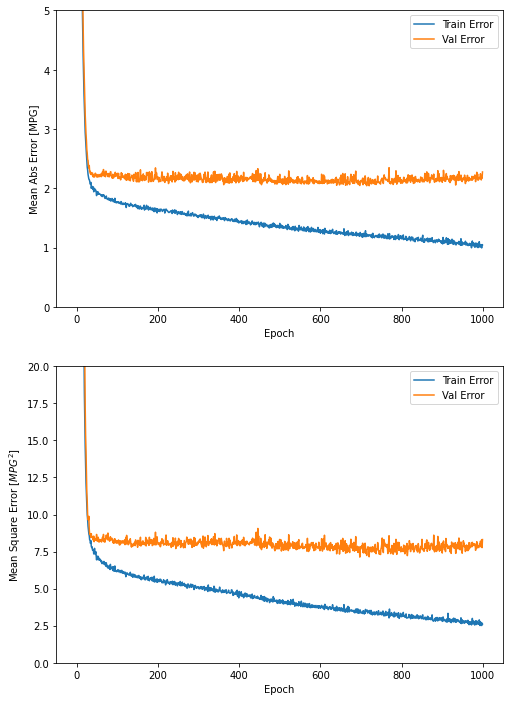

In [41]:
import matplotlib.pyplot as plt

# 시각화
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [42]:
# loss , metric
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.9694 - mae: 2.0018 - mse: 6.9694
테스트 세트의 평균 절대 오차:  2.00 MPG


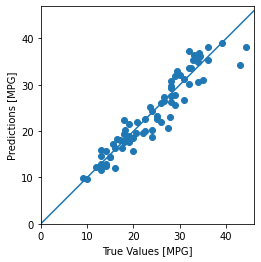

In [43]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

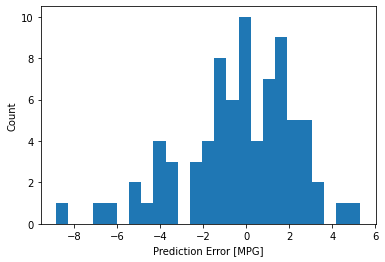

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")